In [1]:
import math
!pip install ucimlrepo
!pip install scikit-learn

In [2]:
pip install --upgrade ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

autompg = fetch_ucirepo(id=9)

X = autompg.data.features
y = autompg.data.targets

data = pd.concat([X, y], axis=1)

cleaned_data = data.dropna()

X = cleaned_data.iloc[:, :-1]
y = cleaned_data.iloc[:, -1]

rows_removed = len(data) - len(cleaned_data)
print(f"Rows removed: {rows_removed}")

Rows removed: 6


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_leftover, y_train, y_leftover = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(X_leftover, y_leftover, test_size=0.5, random_state=42, shuffle=True)

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train = ((X_train - X_mean) / X_std).to_numpy()
X_val = ((X_val - X_mean) / X_std).to_numpy()
X_test = ((X_test - X_mean) / X_std).to_numpy()

y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)

y_train = ((y_train - y_mean) / y_std).to_numpy()
y_val = ((y_val - y_mean) / y_std).to_numpy()
y_test = ((y_test - y_mean) / y_std).to_numpy()


In [5]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((274, 7), (274,), (59, 7), (59,), (59, 7), (59,))

In [6]:
import numpy as np
import math

def mse_loss(y_pred: np.ndarray, y_actual: np.ndarray):
    """
    Calculate the Mean Squared Error loss
    :param y_pred: predicted y values
    :param y_actual: actual y values
    :return: mean squared error
    """
    return 1 / 2 * np.mean(np.square(y_pred - y_actual.flatten()))


def mse_loss_gradient(x: np.ndarray, y_pred: np.ndarray, y_actual: np.ndarray):
    """
    Calculate the partial derivative of the MSE loss function wrt weights and bias
    :param x: x data
    :param y_pred: predicted y data
    :param y_actual: actual y data
    :return: derivative of loss wrt (weight, bias)
    """
    error = y_pred - y_actual.flatten()

    dL_dw = x.T @ error
    dL_db = np.sum(error)

    return dL_dw / len(x), dL_db / len(x)

class LinearRegression:
    def __init__(self, num_features, y_mean, y_std):
        self.num_features = num_features
        self.w = np.random.normal(size=num_features) * 0.01
        self.b  = 0.0
        self.y_mean = y_mean
        self.y_std = y_std


    def y_pred(self, X):
        assert X.shape[1] == self.num_features, "Number of features must match"
        return self.w @ X.T + self.b
    
    def y_pred_mpg(self, X):
        return self.y_pred(X) * y_std + y_mean

    def train(self, X, y, X_val, y_val, epochs = 30, lr = 1e-3, batch_size = 8):
        assert len(X) == len(y), "Number of samples and labels must match"
        x_batches = np.array_split(X, math.ceil(len(X) / batch_size))
        y_batches = np.array_split(y, math.ceil(len(y) / batch_size))
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            total_loss = 0
            bi = 0
            for x_batch, y_batch in zip(x_batches, y_batches):
                y_pred = self.y_pred(x_batch)

                loss = mse_loss(y_pred, y_batch)
                wgrad, bgrad = mse_loss_gradient(x_batch, y_pred, y_batch)

                self.w -= lr * wgrad
                self.b -= lr * bgrad

                total_loss += loss
                bi += 1
            
            train_loss = total_loss / len(x_batches)
            val_loss = mse_loss(self.y_pred(X_val), y_val)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Epoch {epoch + 1} ::: Train Loss: {train_loss} ::: Val Loss: {val_loss}")
        
        return np.array(train_losses), np.array(val_losses)

                


In [9]:
linreg = LinearRegression(X_train.shape[1], y_mean, y_std)
training_loss, validation_loss = linreg.train(X_train, y_train, X_val, y_val, epochs=100, lr=1e-3, batch_size=8)

Epoch 1 ::: Train Loss: 0.43859334757159246 ::: Val Loss: 0.33834796984169296
Epoch 2 ::: Train Loss: 0.3514156940034926 ::: Val Loss: 0.2738160643006094
Epoch 3 ::: Train Loss: 0.28796534621775394 ::: Val Loss: 0.22724667147122832
Epoch 4 ::: Train Loss: 0.2417144914778313 ::: Val Loss: 0.19363070408489938
Epoch 5 ::: Train Loss: 0.20793405516044053 ::: Val Loss: 0.16934937857371687
Epoch 6 ::: Train Loss: 0.18319798058798034 ::: Val Loss: 0.15178962889767825
Epoch 7 ::: Train Loss: 0.16502412085036283 ::: Val Loss: 0.13906570304022686
Epoch 8 ::: Train Loss: 0.15161409635666098 ::: Val Loss: 0.1298176546952925
Epoch 9 ::: Train Loss: 0.14166484575698168 ::: Val Loss: 0.12306551670599579
Epoch 10 ::: Train Loss: 0.13423211316708386 ::: Val Loss: 0.11810379154474437
Epoch 11 ::: Train Loss: 0.12863155901569184 ::: Val Loss: 0.11442513079403832
Epoch 12 ::: Train Loss: 0.12436712596627217 ::: Val Loss: 0.11166514445637238
Epoch 13 ::: Train Loss: 0.12107914864599516 ::: Val Loss: 0.1095

Matplotlib is building the font cache; this may take a moment.


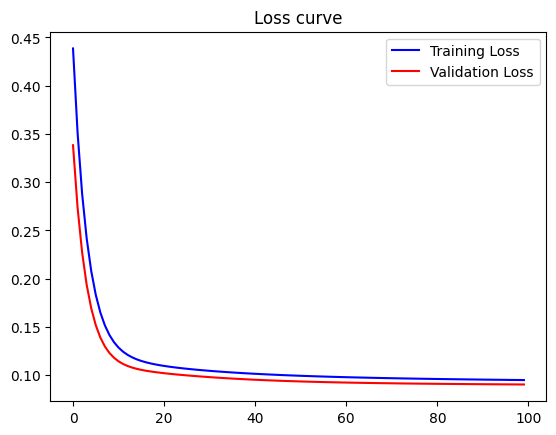

In [13]:
import matplotlib.pyplot as plt

plt.plot(training_loss, color='b', label="Training Loss")
plt.plot(validation_loss, color='r', label="Validation Loss")
plt.title("Loss curve")
plt.legend()

In [14]:
testing_predictions = linreg.y_pred(X_test)
testing_loss = mse_loss(testing_predictions, y_test)
print(f'Testing Loss: {testing_loss}')

Testing Loss: 0.0896210016975451


In [22]:
linreg.y_pred_mpg(X_test[:10]), y_test[:10] * y_std + y_mean

(array([19.52109548, 18.42039642, 29.17348581,  8.99034374, 23.31705642,
        18.56067704,  8.85423116, 11.01521616, 26.68770987, 29.2944144 ]),
 array([20. , 16. , 27. , 13. , 21. , 19.4, 15. , 15. , 22.3, 18. ]))